In [1]:
#install necessary libraries for distance and dimensionality reduction tasks

IS_COLAB = True

if IS_COLAB:
    !pip install tcrdist3
    !pip install umap-learn
    !pip install umap-learn[plot]

In [2]:
if IS_COLAB:
    from google.colab import drive

    drive.mount('/content/drive')
    %ls
    %cd drive/MyDrive/dsmp-2024-groupol1/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive/  sample_data/
/content/drive/MyDrive/dsmp-2024-groupol1


In [3]:
import pandas as pd
df = pd.read_csv('./data/vdjdb.txt', sep="\t")

selected_features = df[['gene','cdr3','v.segm','j.segm','species','mhc.a','mhc.b','mhc.class','antigen.epitope','antigen.species','vdjdb.score', 'complex.id']]

# Select all human data
human_data = selected_features[(selected_features['species'] == 'HomoSapiens') & (selected_features['vdjdb.score'] > 0)]

# Drop duplicate rows
human_data_cols = human_data.columns.difference(['complex.id', 'vdjdb.score'])
print(human_data_cols)
human_data = human_data.drop_duplicates(subset=human_data_cols)

# Delete rows with null values
human_data  = human_data.dropna()
# Print all data
human_data.head()

Index(['antigen.epitope', 'antigen.species', 'cdr3', 'gene', 'j.segm', 'mhc.a',
       'mhc.b', 'mhc.class', 'species', 'v.segm'],
      dtype='object')


,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.species,vdjdb.score,complex.id
0,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,1
1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,1
2,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,0
3,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,2
4,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,2


In [4]:
human_data[human_data['cdr3'] == 'CALSSRGSTLGRLYF']

,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.species,vdjdb.score,complex.id
78121,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,RMEQVDWTV,synthetic,2,27010
78123,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,KLEFMDWRL,synthetic,2,27011
78125,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,WLDNFELCL,synthetic,2,27012
78127,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,TLEYMDWLV,synthetic,2,27013
78129,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,EMMLFDWKV,synthetic,2,27014
78131,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,KLEQLDWTV,HomoSapiens,2,27015
78133,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,TMETIDWKV,HomoSapiens,2,27016
78135,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,TLEELDWCL,HomoSapiens,2,27017
78137,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,LLEDLDWDV,HomoSapiens,2,27018
78139,TRA,CALSSRGSTLGRLYF,TRAV19*01,TRAJ18*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,VLEEVDWLI,HomoSapiens,2,27019


In [5]:
TRB = human_data[human_data['gene'] =='TRB']
# rename the columns for our beta chain matrix calculation
beta_chains = TRB[['cdr3', 'v.segm', 'j.segm', 'antigen.epitope']]
beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene'}, inplace=True)
beta_chains

<ipython-input-5-cdd9bf07a97a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene'}, inplace=True)


,cdr3_b_aa,v_b_gene,j_b_gene,antigen.epitope
1,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
2,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
4,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
6,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
8,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,FLKEKGGL
...,...,...,...,...
92682,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,PQPELPYPQPQL
92684,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,FPQPEQPFPWQP
92686,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,FPQPEQPFPWQP
92690,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,QLQPFPQPELPY


In [85]:
import os
from tcrdist.repertoire import TCRrep
import umap
import umap.plot

import numpy as np
import matplotlib.pyplot as plt

from typing import List

def calculate_dist_and_umap(df: pd.DataFrame,
                            chains: List[str],
                            gene: str) -> pd.DataFrame:
  """
  Function which calculates the T-Cell pairwise distance metric by alpha or beta
  chain using TCR dist and then uses UMAP to reduce dimensionality and outputs a
  plot coloured by epitope.

  """
  df_filtered = df.drop_duplicates(subset = ['cdr3_b_aa', 'antigen.epitope'])

  tr = TCRrep(cell_df = df_filtered,
            organism = 'human',
            chains = chains,
            db_file = 'alphabeta_gammadelta_db.tsv')

  if (len(chains)==1) and (chains[0] == 'beta'):
    distance_matrix = pd.concat([pd.DataFrame(tr.pw_cdr3_b_aa), tr.clone_df[gene]], axis = 1)
    chains = 'beta'
  elif (len(chains)==1) and (chains[0] == 'alpha'):
    distance_matrix = pd.concat([pd.DataFrame(tr.pw_cdr3_a_aa), tr.clone_df[gene]], axis = 1)
    chains = 'alpha'
  else:
    matrix = np.hstack((tr.pw_cdr3_b_aa, tr.pw_cdr3_a_aa))
    distance_matrix = pd.concat([pd.DataFrame(matrix), tr.clone_df[gene]], axis = 1)
    chains = 'alpha_beta'

  value_counts_antigen = distance_matrix[gene].value_counts()
  top_10_value_counts = value_counts_antigen.nlargest(7)
  distance_matrix_filtered = distance_matrix[distance_matrix[gene].isin(top_10_value_counts.index)]

  distances_reduced = umap.UMAP(n_components = 2, n_neighbors = 100, metric='hellinger').fit(distance_matrix_filtered.iloc[:, :-1].values)

  output_dir = 'visualisations'

  f = umap.plot.points(distances_reduced, labels=distance_matrix_filtered[gene])
  f.set_xlabel('UMAP Dimension 1', fontsize=10)
  f.set_ylabel('UMAP Dimension 2', fontsize=10)
  f.set_title(f'UMAP Visualization of {chains}', fontsize=12)

  # Save the figure
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  f.get_figure().savefig(f'{output_dir}/{chains}_chain_umap.png')

  embedding = pd.DataFrame(distances_reduced.embedding_, columns = ['UMAP 1', 'UMAP 2'])
  embedding['Epitope'] = distance_matrix_filtered['antigen.epitope'].tolist()

  distance_df = tr.clone_df[tr.clone_df[gene].isin(top_10_value_counts.index)]


  return embedding, distance_df

/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.cell_df['count'] = 1


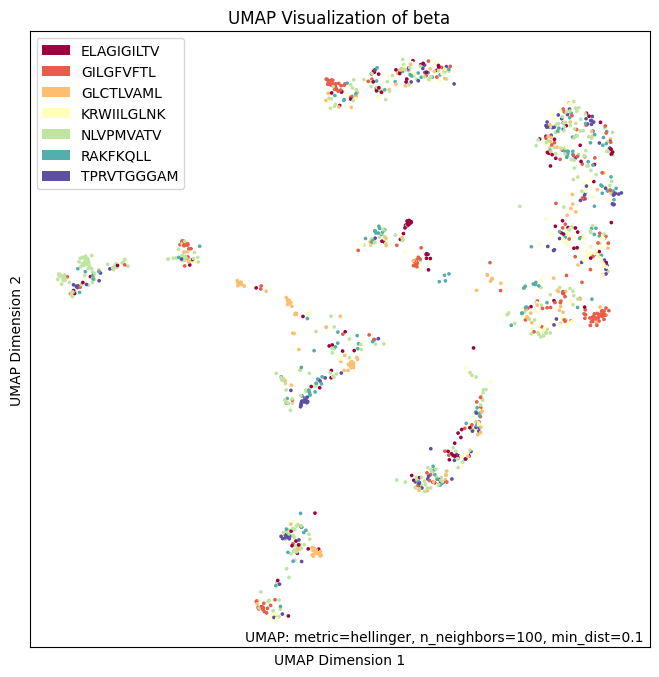

In [107]:
beta_dist_matrix = calculate_dist_and_umap(beta_chains, ['beta'], 'antigen.epitope')

In [108]:
distances_reduced = beta_dist_matrix[0]
original_df = beta_dist_matrix[1]

original_df.reset_index(inplace = True)

In [109]:
original_df['cdr3_b_aa'].value_counts()

cdr3_b_aa
CASSQRSTGELFF     2
CASSFDGVYEQYF     2
CASSLRSTGELFF     2
CASSTRSTGELFF     2
CASSIVGGNEQFF     2
                 ..
CASSLGVNAVEQYF    1
CASSLGTSSYEQYF    1
CASSLGTSAYEQYF    1
CASSLGTPNEQFF     1
CTRAYNQPQHF       1
Name: count, Length: 1365, dtype: int64

In [110]:
original_df[original_df['cdr3_b_aa'] == 'CASSYVGLGSPLHF']

,index,cdr3_b_aa,v_b_gene,j_b_gene,antigen.epitope,cdr1_b_aa,cdr2_b_aa,pmhc_b_aa,count,clone_id
1109,3766,CASSYVGLGSPLHF,TRBV6-3*01,TRBJ1-6*01,ELAGIGILTV,MNH.......EY,SVG....EGT,L.KKQN,1,3767
1110,3767,CASSYVGLGSPLHF,TRBV6-5*01,TRBJ1-6*01,NLVPMVATV,MNH.......EY,SVG....AGI,S.TTED,1,3768


In [111]:
distances_reduced = pd.concat((distances_reduced, original_df['cdr3_b_aa']), axis = 1)

In [112]:
distances_reduced

,UMAP 1,UMAP 2,Epitope,cdr3_b_aa
0,7.073062,12.737632,NLVPMVATV,CAAGTRTDTQYF
1,6.695997,3.139311,GLCTLVAML,CAGGTGETSPGELFF
2,11.985312,11.622396,RAKFKQLL,CAGRPRLAGGNNEQFF
3,6.004832,2.088346,NLVPMVATV,CAIDRVGTGELFF
4,9.560754,5.167187,RAKFKQLL,CAISATGAVTEAFF
...,...,...,...,...
1371,8.187374,9.620841,GLCTLVAML,CSVTGDRRSNQPQHF
1372,1.941772,8.626073,RAKFKQLL,CSVTSERTGTNWGYTF
1373,7.511356,12.699291,NLVPMVATV,CSVVAGGADTQYF
1374,4.282032,9.474862,NLVPMVATV,CSVVDYGYTF


In [113]:
#distances_reduced = pd.concat((distances_reduced, pd.get_dummies(distances_reduced['Epitope'], dtype = int)), axis = 1)

In [114]:
#distances_reduced_grouped = distances_reduced.groupby(['cdr3_b_aa'])[list(distances_reduced.columns[4:])].sum().reset_index()

In [115]:
distances_reduced_final = distances_reduced.drop_duplicates(subset = ['cdr3_b_aa'])

distances_reduced_final

,UMAP 1,UMAP 2,Epitope,cdr3_b_aa
0,7.073062,12.737632,NLVPMVATV,CAAGTRTDTQYF
1,6.695997,3.139311,GLCTLVAML,CAGGTGETSPGELFF
2,11.985312,11.622396,RAKFKQLL,CAGRPRLAGGNNEQFF
3,6.004832,2.088346,NLVPMVATV,CAIDRVGTGELFF
4,9.560754,5.167187,RAKFKQLL,CAISATGAVTEAFF
...,...,...,...,...
1371,8.187374,9.620841,GLCTLVAML,CSVTGDRRSNQPQHF
1372,1.941772,8.626073,RAKFKQLL,CSVTSERTGTNWGYTF
1373,7.511356,12.699291,NLVPMVATV,CSVVAGGADTQYF
1374,4.282032,9.474862,NLVPMVATV,CSVVDYGYTF


In [116]:
distances_reduced_final['Epitope categorical'] = pd.Categorical(distances_reduced_final['Epitope']).codes

<ipython-input-116-e89a7661c6a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distances_reduced_final['Epitope categorical'] = pd.Categorical(distances_reduced_final['Epitope']).codes


In [117]:
distances_reduced_final

,UMAP 1,UMAP 2,Epitope,cdr3_b_aa,Epitope categorical
0,7.073062,12.737632,NLVPMVATV,CAAGTRTDTQYF,4
1,6.695997,3.139311,GLCTLVAML,CAGGTGETSPGELFF,2
2,11.985312,11.622396,RAKFKQLL,CAGRPRLAGGNNEQFF,5
3,6.004832,2.088346,NLVPMVATV,CAIDRVGTGELFF,4
4,9.560754,5.167187,RAKFKQLL,CAISATGAVTEAFF,5
...,...,...,...,...,...
1371,8.187374,9.620841,GLCTLVAML,CSVTGDRRSNQPQHF,2
1372,1.941772,8.626073,RAKFKQLL,CSVTSERTGTNWGYTF,5
1373,7.511356,12.699291,NLVPMVATV,CSVVAGGADTQYF,4
1374,4.282032,9.474862,NLVPMVATV,CSVVDYGYTF,4


In [118]:
X = distances_reduced_final[['UMAP 1', 'UMAP 2']]
y = distances_reduced_final['Epitope categorical'].values

In [161]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split



# Create a KNN classifier
knn = KNeighborsClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 50)


def grid_search_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 50)
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': np.arange(1, 100)}
    # Create a GridSearchCV object
    grid_search = GridSearchCV(knn, param_grid, cv=5)
    # train

    grid_search.fit(X_train, y_train)

    best_k = grid_search.best_params_['n_neighbors']

    # Create a new KNN model with the best parameters
    knn_best = KNeighborsClassifier(n_neighbors=best_k)
    knn_best.fit(X_train, y_train)
    # Test
    print("Best parameters: ", best_k)

    y_pred = knn_best.predict(X_test)
    print(classification_report(y_pred, y_test))

grid_search_classifier(X, y)

Best parameters:  6
              precision    recall  f1-score   support

           0       0.28      0.29      0.28        28
           1       0.63      0.57      0.60        46
           2       0.39      0.59      0.47        22
           3       0.54      0.47      0.50        32
           4       0.55      0.46      0.50       101
           5       0.19      0.35      0.25        17
           6       0.48      0.48      0.48        27

    accuracy                           0.47       273
   macro avg       0.44      0.46      0.44       273
weighted avg       0.49      0.47      0.47       273

